## Convolutional Autoencoder

In this notebook, we will be implementing a simple Autoencoder for images. Autoencoders are a type of neural networks that learn the features from the data by compressing the data and then reproducing the output same as input. 

### Architecture:

***Input Data  =>  Encoder  => Hidden Layer  =>   Decoder  =>  Output Data***

Note that the Input Data == Output Data.

The number of nerons in the Input Layer i.e. Encoder == number of neurons in Output Layer i.e. Decoder.

The hidden layer is where the magic happens. The hidden layer may have the number of neurons that might be less than the Output Layer (i.e. "Undercomplete Autoencoder") or if the number of neurons are more in the Hidden layer than the Output Layer (i.e. "Overcomplete Autoencoder").

The Encoder for a Convolutional Autoencoder uses Convolution layers instead of the Fully Connected Layers as in the linear Autoencoder followed by MaxPooling layer. 

At the Hidden Layer, the model takes in the data from a higher dimension and compresses it into lower dimension by learning features from the Input Data.

Once the features are learnt, the data moves to the Decoder part which uses Transposed Convolutions along with Maxpooling to get the final image equal to the size of the Input Image. Sometimes, during the decoding process, the image gets blurry or appears in form of blocks. So, to avoid that, we use Upsampling.

In [1]:
# Import Dependencies
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load Dataset
mnist = input_data.read_data_sets('./dataset/input_data/', one_hot=True)

Extracting ./dataset/input_data/train-images-idx3-ubyte.gz
Extracting ./dataset/input_data/train-labels-idx1-ubyte.gz
Extracting ./dataset/input_data/t10k-images-idx3-ubyte.gz
Extracting ./dataset/input_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Shapes of training set
print("Training set (images) shape: ",mnist.train.images.shape)
print("Training set (labels) shape: ",mnist.train.labels.shape)

# Shapes of test set
print("Test set (images) shape: ", mnist.test.images.shape)
print("Test set (labels) shape: ", mnist.test.labels.shape)

Training set (images) shape:  (55000, 784)
Training set (labels) shape:  (55000, 10)
Test set (images) shape:  (10000, 784)
Test set (labels) shape:  (10000, 10)


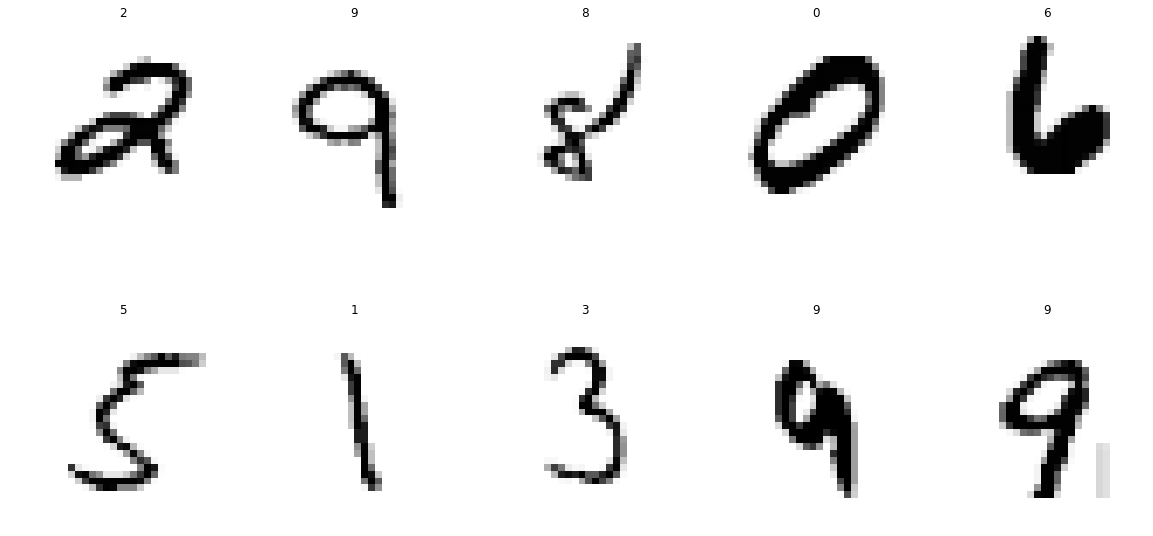

In [4]:
# Plot Random Image
n = np.random.randint(0,55000,10)
labels = []
with tf.Session() as sess:
    for i in range(len(n)):
        l = tf.argmax(mnist.train.labels[n][i], axis=0)
        labels.append(sess.run(l))
sess.close()

# Plot Images
fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20,10))
u = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(mnist.train.images[n][u].reshape(28,28), cmap='Greys')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(labels[u])
        u += 1

In [5]:
# Helper Function to Plot Images
def plot_images(out_img=None):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    test_imgs = mnist.test.images[:10]
    
    for images, row in zip([test_imgs, out_img], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.show()

### Autoencoder Modle

In [6]:
# Define Constants
# Learning Rate
lr = 0.001

In [7]:
# Define Placeholders
# Input Image
input_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="input_image")

# Target Image / Reproduced Image
target_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="output_image")

### Encoder

In [8]:
# Encoder Module
with tf.name_scope('Encoder'):
    # First Convolutional layer
    conv1 = tf.layers.conv2d(inputs=input_image, filters= 16, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv1')
    # Max Pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool1')
    # Second Convolutional layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters= 8, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv2')
    # Max Pooling 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool2')
    # Third Convolutional layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters= 8, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv3')
    # Max Pooling 3
    encoded_image = tf.layers.max_pooling2d(inputs=conv3, pool_size=(2,2), strides=(2,2), padding= 'same', name='Encoded_Image')

### Decoder

For the decoder we have two options:

**1. Use Transposed Convolutions:**

This works in opposite way as compared to a convolution process and gets us the original image size output. The drawback of using thi sapproach is that in the output image generated, we may see some checkblocks. Hence, the image is not as clear as expected.

**2. Resize using UpSampling and use Convolutions:**

Using this approach has proven to be better as compared to the first approach as using this we can get much better images at the output.

In [9]:
# Decoder Module
# Input = encoded_image
with tf.name_scope('Decoder'):
    # Upsampling Image to get Better Quality Image at Output
    upsample_image1 = tf.image.resize_images(images=encoded_image, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv1 = tf.layers.conv2d(inputs=upsample_image1, filters= 8, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv1')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image2 = tf.image.resize_images(images=deconv1, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv2 = tf.layers.conv2d(inputs=upsample_image2, filters= 8, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv2')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image3 = tf.image.resize_images(images=deconv2, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv3 = tf.layers.conv2d(inputs=upsample_image3, filters= 16, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv3')
    # Test Dropout
    dropout = tf.layers.dropout(inputs=deconv3, rate=0.4)
    logits = tf.layers.conv2d(inputs=dropout, filters=1, kernel_size=(3,3), padding='same', activation=None, name='logits')
    # Pass logits through sigmoid to get reconstructed image
    decoded_image = tf.nn.sigmoid(logits, name='Decoded_Image')

In [10]:
# Cost Function:Cross Entropy With Logits
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_image, logits=logits))

# Optimizer
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

# Define a Model Saver
save_model = tf.train.Saver()

# Test Images
test_images = mnist.test.images[:10]

In [11]:
# Initialize all Variables
init = tf.global_variables_initializer()

Epoch: 0/20	 Training Loss: 0.6885
Epoch: 0/20	 Training Loss: 0.6824
Epoch: 0/20	 Training Loss: 0.6745
Epoch: 0/20	 Training Loss: 0.6654
Epoch: 0/20	 Training Loss: 0.6543
Epoch: 0/20	 Training Loss: 0.6412
Epoch: 0/20	 Training Loss: 0.6241
Epoch: 0/20	 Training Loss: 0.6073
Epoch: 0/20	 Training Loss: 0.5865
Epoch: 0/20	 Training Loss: 0.5674
Epoch: 0/20	 Training Loss: 0.5527
Epoch: 0/20	 Training Loss: 0.5358
Epoch: 0/20	 Training Loss: 0.5282
Epoch: 0/20	 Training Loss: 0.5412
Epoch: 0/20	 Training Loss: 0.5402
Epoch: 0/20	 Training Loss: 0.5377
Epoch: 0/20	 Training Loss: 0.5312
Epoch: 0/20	 Training Loss: 0.5285
Epoch: 0/20	 Training Loss: 0.5268
Epoch: 0/20	 Training Loss: 0.5046
Epoch: 0/20	 Training Loss: 0.5082
Epoch: 0/20	 Training Loss: 0.5013
Epoch: 0/20	 Training Loss: 0.4915
Epoch: 0/20	 Training Loss: 0.4909
Epoch: 0/20	 Training Loss: 0.4902
Epoch: 0/20	 Training Loss: 0.4948
Epoch: 0/20	 Training Loss: 0.4823
Epoch: 0/20	 Training Loss: 0.4761
Epoch: 0/20	 Trainin

Epoch: 0/20	 Training Loss: 0.1586
Epoch: 0/20	 Training Loss: 0.1611
Epoch: 0/20	 Training Loss: 0.1576
Epoch: 0/20	 Training Loss: 0.1587
Epoch: 0/20	 Training Loss: 0.1526
Epoch: 0/20	 Training Loss: 0.1614
Epoch: 0/20	 Training Loss: 0.1586
Epoch: 0/20	 Training Loss: 0.1591
Epoch: 0/20	 Training Loss: 0.1580
Epoch: 0/20	 Training Loss: 0.1589
Epoch: 0/20	 Training Loss: 0.1557
Epoch: 0/20	 Training Loss: 0.1616
Epoch: 0/20	 Training Loss: 0.1536
Epoch: 0/20	 Training Loss: 0.1574
Epoch: 0/20	 Training Loss: 0.1557
Epoch: 0/20	 Training Loss: 0.1561
Epoch: 0/20	 Training Loss: 0.1610
Epoch: 0/20	 Training Loss: 0.1577
Epoch: 0/20	 Training Loss: 0.1580
Epoch: 0/20	 Training Loss: 0.1569
Epoch: 0/20	 Training Loss: 0.1534
Epoch: 0/20	 Training Loss: 0.1561
Epoch: 0/20	 Training Loss: 0.1541
Epoch: 0/20	 Training Loss: 0.1550
Epoch: 0/20	 Training Loss: 0.1538
Epoch: 0/20	 Training Loss: 0.1571
Epoch: 0/20	 Training Loss: 0.1546
Epoch: 0/20	 Training Loss: 0.1590
Epoch: 0/20	 Trainin

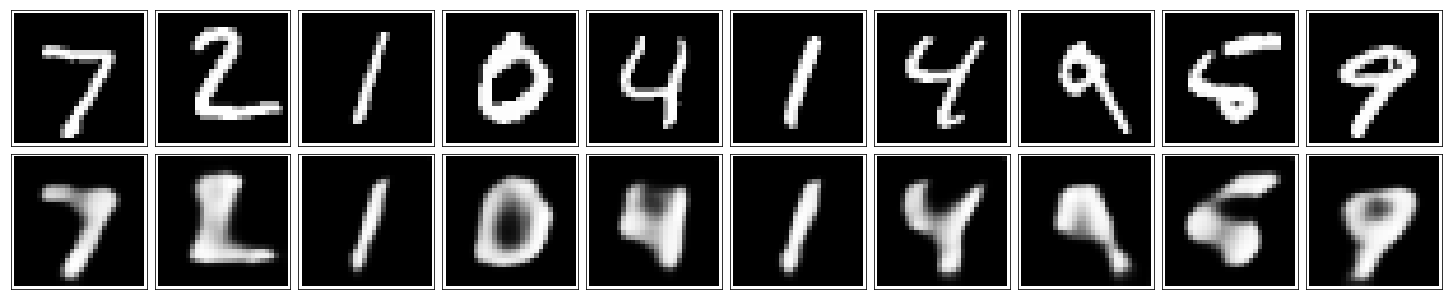

Epoch: 1/20	 Training Loss: 0.1506
Epoch: 1/20	 Training Loss: 0.1561
Epoch: 1/20	 Training Loss: 0.1538
Epoch: 1/20	 Training Loss: 0.1555
Epoch: 1/20	 Training Loss: 0.1556
Epoch: 1/20	 Training Loss: 0.1462
Epoch: 1/20	 Training Loss: 0.1535
Epoch: 1/20	 Training Loss: 0.1484
Epoch: 1/20	 Training Loss: 0.1501
Epoch: 1/20	 Training Loss: 0.1526
Epoch: 1/20	 Training Loss: 0.1498
Epoch: 1/20	 Training Loss: 0.1492
Epoch: 1/20	 Training Loss: 0.1550
Epoch: 1/20	 Training Loss: 0.1540
Epoch: 1/20	 Training Loss: 0.1563
Epoch: 1/20	 Training Loss: 0.1594
Epoch: 1/20	 Training Loss: 0.1534
Epoch: 1/20	 Training Loss: 0.1533
Epoch: 1/20	 Training Loss: 0.1518
Epoch: 1/20	 Training Loss: 0.1536
Epoch: 1/20	 Training Loss: 0.1494
Epoch: 1/20	 Training Loss: 0.1533
Epoch: 1/20	 Training Loss: 0.1523
Epoch: 1/20	 Training Loss: 0.1536
Epoch: 1/20	 Training Loss: 0.1464
Epoch: 1/20	 Training Loss: 0.1496
Epoch: 1/20	 Training Loss: 0.1469
Epoch: 1/20	 Training Loss: 0.1491
Epoch: 1/20	 Trainin

Epoch: 1/20	 Training Loss: 0.1365
Epoch: 1/20	 Training Loss: 0.1335
Epoch: 1/20	 Training Loss: 0.1343
Epoch: 1/20	 Training Loss: 0.1334
Epoch: 1/20	 Training Loss: 0.1362
Epoch: 1/20	 Training Loss: 0.1379
Epoch: 1/20	 Training Loss: 0.1342
Epoch: 1/20	 Training Loss: 0.1317
Epoch: 1/20	 Training Loss: 0.1301
Epoch: 1/20	 Training Loss: 0.1322
Epoch: 1/20	 Training Loss: 0.1330
Epoch: 1/20	 Training Loss: 0.1375
Epoch: 1/20	 Training Loss: 0.1355
Epoch: 1/20	 Training Loss: 0.1334
Epoch: 1/20	 Training Loss: 0.1366
Epoch: 1/20	 Training Loss: 0.1307
Epoch: 1/20	 Training Loss: 0.1301
Epoch: 1/20	 Training Loss: 0.1361
Epoch: 1/20	 Training Loss: 0.1367
Epoch: 1/20	 Training Loss: 0.1280
Epoch: 1/20	 Training Loss: 0.1329
Epoch: 1/20	 Training Loss: 0.1335
Epoch: 1/20	 Training Loss: 0.1345
Epoch: 1/20	 Training Loss: 0.1257
Epoch: 1/20	 Training Loss: 0.1348
Epoch: 1/20	 Training Loss: 0.1305
Epoch: 1/20	 Training Loss: 0.1315
Epoch: 1/20	 Training Loss: 0.1308
Epoch: 1/20	 Trainin

Epoch: 2/20	 Training Loss: 0.1237
Epoch: 2/20	 Training Loss: 0.1204
Epoch: 2/20	 Training Loss: 0.1175
Epoch: 2/20	 Training Loss: 0.1243
Epoch: 2/20	 Training Loss: 0.1247
Epoch: 2/20	 Training Loss: 0.1239
Epoch: 2/20	 Training Loss: 0.1254
Epoch: 2/20	 Training Loss: 0.1242
Epoch: 2/20	 Training Loss: 0.1182
Epoch: 2/20	 Training Loss: 0.1245
Epoch: 2/20	 Training Loss: 0.1305
Epoch: 2/20	 Training Loss: 0.1238
Epoch: 2/20	 Training Loss: 0.1271
Epoch: 2/20	 Training Loss: 0.1224
Epoch: 2/20	 Training Loss: 0.1260
Epoch: 2/20	 Training Loss: 0.1227
Epoch: 2/20	 Training Loss: 0.1233
Epoch: 2/20	 Training Loss: 0.1203
Epoch: 2/20	 Training Loss: 0.1289
Epoch: 2/20	 Training Loss: 0.1248
Epoch: 2/20	 Training Loss: 0.1275
Epoch: 2/20	 Training Loss: 0.1256
Epoch: 2/20	 Training Loss: 0.1238
Epoch: 2/20	 Training Loss: 0.1242
Epoch: 2/20	 Training Loss: 0.1246
Epoch: 2/20	 Training Loss: 0.1259
Epoch: 2/20	 Training Loss: 0.1221
Epoch: 2/20	 Training Loss: 0.1222
Epoch: 2/20	 Trainin

Epoch: 3/20	 Training Loss: 0.1189
Epoch: 3/20	 Training Loss: 0.1208
Epoch: 3/20	 Training Loss: 0.1207
Epoch: 3/20	 Training Loss: 0.1218
Epoch: 3/20	 Training Loss: 0.1208
Epoch: 3/20	 Training Loss: 0.1153
Epoch: 3/20	 Training Loss: 0.1239
Epoch: 3/20	 Training Loss: 0.1186
Epoch: 3/20	 Training Loss: 0.1127
Epoch: 3/20	 Training Loss: 0.1179
Epoch: 3/20	 Training Loss: 0.1203
Epoch: 3/20	 Training Loss: 0.1225
Epoch: 3/20	 Training Loss: 0.1236
Epoch: 3/20	 Training Loss: 0.1171
Epoch: 3/20	 Training Loss: 0.1170
Epoch: 3/20	 Training Loss: 0.1119
Epoch: 3/20	 Training Loss: 0.1219
Epoch: 3/20	 Training Loss: 0.1237
Epoch: 3/20	 Training Loss: 0.1192
Epoch: 3/20	 Training Loss: 0.1207
Epoch: 3/20	 Training Loss: 0.1177
Epoch: 3/20	 Training Loss: 0.1218
Epoch: 3/20	 Training Loss: 0.1213
Epoch: 3/20	 Training Loss: 0.1169
Epoch: 3/20	 Training Loss: 0.1255
Epoch: 3/20	 Training Loss: 0.1231
Epoch: 3/20	 Training Loss: 0.1171
Epoch: 3/20	 Training Loss: 0.1179
Epoch: 3/20	 Trainin

Epoch: 4/20	 Training Loss: 0.1150
Epoch: 4/20	 Training Loss: 0.1172
Epoch: 4/20	 Training Loss: 0.1188
Epoch: 4/20	 Training Loss: 0.1174
Epoch: 4/20	 Training Loss: 0.1195
Epoch: 4/20	 Training Loss: 0.1178
Epoch: 4/20	 Training Loss: 0.1165
Epoch: 4/20	 Training Loss: 0.1214
Epoch: 4/20	 Training Loss: 0.1143
Epoch: 4/20	 Training Loss: 0.1134
Epoch: 4/20	 Training Loss: 0.1136
Epoch: 4/20	 Training Loss: 0.1197
Epoch: 4/20	 Training Loss: 0.1150
Epoch: 4/20	 Training Loss: 0.1161
Epoch: 4/20	 Training Loss: 0.1164
Epoch: 4/20	 Training Loss: 0.1140
Epoch: 4/20	 Training Loss: 0.1166
Epoch: 4/20	 Training Loss: 0.1183
Epoch: 4/20	 Training Loss: 0.1115
Epoch: 4/20	 Training Loss: 0.1216
Epoch: 4/20	 Training Loss: 0.1149
Epoch: 4/20	 Training Loss: 0.1151
Epoch: 4/20	 Training Loss: 0.1177
Epoch: 4/20	 Training Loss: 0.1210
Epoch: 4/20	 Training Loss: 0.1171
Epoch: 4/20	 Training Loss: 0.1121
Epoch: 4/20	 Training Loss: 0.1154
Epoch: 4/20	 Training Loss: 0.1162
Epoch: 4/20	 Trainin

Epoch: 5/20	 Training Loss: 0.1156
Epoch: 5/20	 Training Loss: 0.1156
Epoch: 5/20	 Training Loss: 0.1167
Epoch: 5/20	 Training Loss: 0.1151
Epoch: 5/20	 Training Loss: 0.1157
Epoch: 5/20	 Training Loss: 0.1145
Epoch: 5/20	 Training Loss: 0.1176
Epoch: 5/20	 Training Loss: 0.1155
Epoch: 5/20	 Training Loss: 0.1131
Epoch: 5/20	 Training Loss: 0.1183
Epoch: 5/20	 Training Loss: 0.1119
Epoch: 5/20	 Training Loss: 0.1184
Epoch: 5/20	 Training Loss: 0.1148
Epoch: 5/20	 Training Loss: 0.1112
Epoch: 5/20	 Training Loss: 0.1105
Epoch: 5/20	 Training Loss: 0.1152
Epoch: 5/20	 Training Loss: 0.1102
Epoch: 5/20	 Training Loss: 0.1150
Epoch: 5/20	 Training Loss: 0.1157
Epoch: 5/20	 Training Loss: 0.1141
Epoch: 5/20	 Training Loss: 0.1166
Epoch: 5/20	 Training Loss: 0.1081
Epoch: 5/20	 Training Loss: 0.1150
Epoch: 5/20	 Training Loss: 0.1154
Epoch: 5/20	 Training Loss: 0.1118
Epoch: 5/20	 Training Loss: 0.1103
Epoch: 5/20	 Training Loss: 0.1110
Epoch: 5/20	 Training Loss: 0.1117
Epoch: 5/20	 Trainin

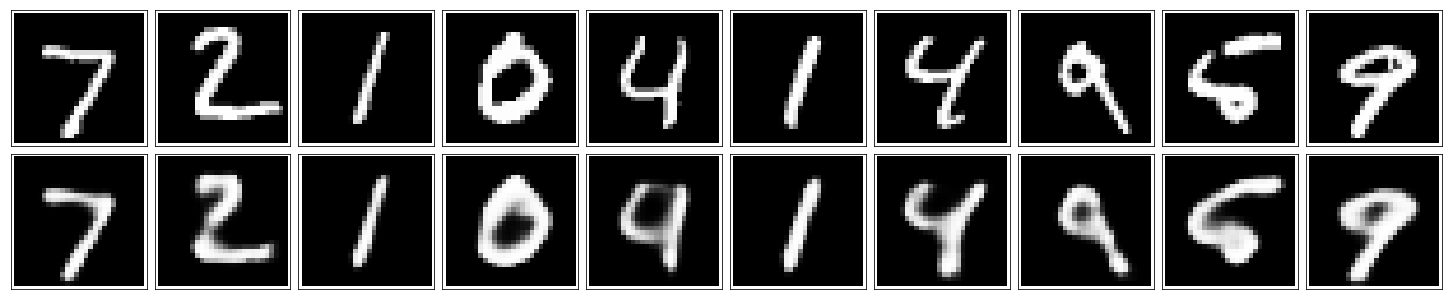

Epoch: 6/20	 Training Loss: 0.1096
Epoch: 6/20	 Training Loss: 0.1116
Epoch: 6/20	 Training Loss: 0.1129
Epoch: 6/20	 Training Loss: 0.1121
Epoch: 6/20	 Training Loss: 0.1102
Epoch: 6/20	 Training Loss: 0.1115
Epoch: 6/20	 Training Loss: 0.1124
Epoch: 6/20	 Training Loss: 0.1140
Epoch: 6/20	 Training Loss: 0.1184
Epoch: 6/20	 Training Loss: 0.1071
Epoch: 6/20	 Training Loss: 0.1126
Epoch: 6/20	 Training Loss: 0.1134
Epoch: 6/20	 Training Loss: 0.1108
Epoch: 6/20	 Training Loss: 0.1159
Epoch: 6/20	 Training Loss: 0.1113
Epoch: 6/20	 Training Loss: 0.1083
Epoch: 6/20	 Training Loss: 0.1167
Epoch: 6/20	 Training Loss: 0.1103
Epoch: 6/20	 Training Loss: 0.1125
Epoch: 6/20	 Training Loss: 0.1101
Epoch: 6/20	 Training Loss: 0.1104
Epoch: 6/20	 Training Loss: 0.1152
Epoch: 6/20	 Training Loss: 0.1123
Epoch: 6/20	 Training Loss: 0.1090
Epoch: 6/20	 Training Loss: 0.1138
Epoch: 6/20	 Training Loss: 0.1121
Epoch: 6/20	 Training Loss: 0.1090
Epoch: 6/20	 Training Loss: 0.1123
Epoch: 6/20	 Trainin

Epoch: 6/20	 Training Loss: 0.1111
Epoch: 6/20	 Training Loss: 0.1056
Epoch: 6/20	 Training Loss: 0.1085
Epoch: 6/20	 Training Loss: 0.1137
Epoch: 6/20	 Training Loss: 0.1097
Epoch: 6/20	 Training Loss: 0.1138
Epoch: 6/20	 Training Loss: 0.1123
Epoch: 6/20	 Training Loss: 0.1082
Epoch: 6/20	 Training Loss: 0.1092
Epoch: 6/20	 Training Loss: 0.1096
Epoch: 6/20	 Training Loss: 0.1122
Epoch: 6/20	 Training Loss: 0.1138
Epoch: 6/20	 Training Loss: 0.1129
Epoch: 6/20	 Training Loss: 0.1078
Epoch: 6/20	 Training Loss: 0.1113
Epoch: 6/20	 Training Loss: 0.1106
Epoch: 6/20	 Training Loss: 0.1123
Epoch: 6/20	 Training Loss: 0.1103
Epoch: 6/20	 Training Loss: 0.1131
Epoch: 6/20	 Training Loss: 0.1079
Epoch: 6/20	 Training Loss: 0.1111
Epoch: 6/20	 Training Loss: 0.1065
Epoch: 6/20	 Training Loss: 0.1062
Epoch: 6/20	 Training Loss: 0.1065
Epoch: 6/20	 Training Loss: 0.1065
Epoch: 6/20	 Training Loss: 0.1055
Epoch: 6/20	 Training Loss: 0.1090
Epoch: 6/20	 Training Loss: 0.1077
Epoch: 6/20	 Trainin

Epoch: 7/20	 Training Loss: 0.1094
Epoch: 7/20	 Training Loss: 0.1085
Epoch: 7/20	 Training Loss: 0.1054
Epoch: 7/20	 Training Loss: 0.1070
Epoch: 7/20	 Training Loss: 0.1080
Epoch: 7/20	 Training Loss: 0.1085
Epoch: 7/20	 Training Loss: 0.1114
Epoch: 7/20	 Training Loss: 0.1108
Epoch: 7/20	 Training Loss: 0.1079
Epoch: 7/20	 Training Loss: 0.1075
Epoch: 7/20	 Training Loss: 0.1086
Epoch: 7/20	 Training Loss: 0.1099
Epoch: 7/20	 Training Loss: 0.1028
Epoch: 7/20	 Training Loss: 0.1092
Epoch: 7/20	 Training Loss: 0.1076
Epoch: 7/20	 Training Loss: 0.1138
Epoch: 7/20	 Training Loss: 0.1113
Epoch: 7/20	 Training Loss: 0.1069
Epoch: 7/20	 Training Loss: 0.1102
Epoch: 7/20	 Training Loss: 0.1056
Epoch: 7/20	 Training Loss: 0.1072
Epoch: 7/20	 Training Loss: 0.1103
Epoch: 7/20	 Training Loss: 0.1064
Epoch: 7/20	 Training Loss: 0.1087
Epoch: 7/20	 Training Loss: 0.1092
Epoch: 7/20	 Training Loss: 0.1085
Epoch: 7/20	 Training Loss: 0.1055
Epoch: 7/20	 Training Loss: 0.1064
Epoch: 7/20	 Trainin

Epoch: 8/20	 Training Loss: 0.1065
Epoch: 8/20	 Training Loss: 0.1031
Epoch: 8/20	 Training Loss: 0.1084
Epoch: 8/20	 Training Loss: 0.1053
Epoch: 8/20	 Training Loss: 0.1058
Epoch: 8/20	 Training Loss: 0.1074
Epoch: 8/20	 Training Loss: 0.1046
Epoch: 8/20	 Training Loss: 0.1089
Epoch: 8/20	 Training Loss: 0.1100
Epoch: 8/20	 Training Loss: 0.1060
Epoch: 8/20	 Training Loss: 0.1076
Epoch: 8/20	 Training Loss: 0.1078
Epoch: 8/20	 Training Loss: 0.1072
Epoch: 8/20	 Training Loss: 0.1114
Epoch: 8/20	 Training Loss: 0.1064
Epoch: 8/20	 Training Loss: 0.1081
Epoch: 8/20	 Training Loss: 0.1100
Epoch: 8/20	 Training Loss: 0.1081
Epoch: 8/20	 Training Loss: 0.1049
Epoch: 8/20	 Training Loss: 0.1059
Epoch: 8/20	 Training Loss: 0.1073
Epoch: 8/20	 Training Loss: 0.1080
Epoch: 8/20	 Training Loss: 0.1057
Epoch: 8/20	 Training Loss: 0.1095
Epoch: 8/20	 Training Loss: 0.1107
Epoch: 8/20	 Training Loss: 0.1072
Epoch: 8/20	 Training Loss: 0.1058
Epoch: 8/20	 Training Loss: 0.1067
Epoch: 8/20	 Trainin

Epoch: 9/20	 Training Loss: 0.1080
Epoch: 9/20	 Training Loss: 0.1062
Epoch: 9/20	 Training Loss: 0.1069
Epoch: 9/20	 Training Loss: 0.1086
Epoch: 9/20	 Training Loss: 0.1073
Epoch: 9/20	 Training Loss: 0.1110
Epoch: 9/20	 Training Loss: 0.1066
Epoch: 9/20	 Training Loss: 0.1082
Epoch: 9/20	 Training Loss: 0.1047
Epoch: 9/20	 Training Loss: 0.1060
Epoch: 9/20	 Training Loss: 0.1050
Epoch: 9/20	 Training Loss: 0.1084
Epoch: 9/20	 Training Loss: 0.1064
Epoch: 9/20	 Training Loss: 0.1066
Epoch: 9/20	 Training Loss: 0.1029
Epoch: 9/20	 Training Loss: 0.1070
Epoch: 9/20	 Training Loss: 0.1044
Epoch: 9/20	 Training Loss: 0.1102
Epoch: 9/20	 Training Loss: 0.1071
Epoch: 9/20	 Training Loss: 0.1076
Epoch: 9/20	 Training Loss: 0.1046
Epoch: 9/20	 Training Loss: 0.1054
Epoch: 9/20	 Training Loss: 0.1074
Epoch: 9/20	 Training Loss: 0.1100
Epoch: 9/20	 Training Loss: 0.1080
Epoch: 9/20	 Training Loss: 0.1115
Epoch: 9/20	 Training Loss: 0.1049
Epoch: 9/20	 Training Loss: 0.1128
Epoch: 9/20	 Trainin

Epoch: 10/20	 Training Loss: 0.1047
Epoch: 10/20	 Training Loss: 0.1093
Epoch: 10/20	 Training Loss: 0.1058
Epoch: 10/20	 Training Loss: 0.1100
Epoch: 10/20	 Training Loss: 0.1077
Epoch: 10/20	 Training Loss: 0.1045
Epoch: 10/20	 Training Loss: 0.1036
Epoch: 10/20	 Training Loss: 0.1041
Epoch: 10/20	 Training Loss: 0.1047
Epoch: 10/20	 Training Loss: 0.1038
Epoch: 10/20	 Training Loss: 0.1017
Epoch: 10/20	 Training Loss: 0.1031
Epoch: 10/20	 Training Loss: 0.1109
Epoch: 10/20	 Training Loss: 0.1055
Epoch: 10/20	 Training Loss: 0.1045
Epoch: 10/20	 Training Loss: 0.1064
Epoch: 10/20	 Training Loss: 0.1073
Epoch: 10/20	 Training Loss: 0.1064
Epoch: 10/20	 Training Loss: 0.1043
Epoch: 10/20	 Training Loss: 0.1061
Epoch: 10/20	 Training Loss: 0.1097
Epoch: 10/20	 Training Loss: 0.1065
Epoch: 10/20	 Training Loss: 0.1047
Epoch: 10/20	 Training Loss: 0.1050
Epoch: 10/20	 Training Loss: 0.1070
Epoch: 10/20	 Training Loss: 0.1079
Epoch: 10/20	 Training Loss: 0.1052
Epoch: 10/20	 Training Loss:

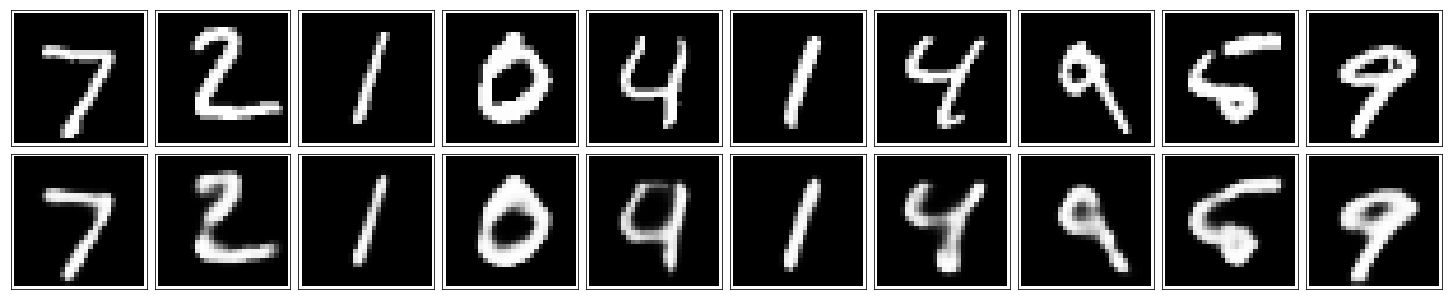

Epoch: 11/20	 Training Loss: 0.1075
Epoch: 11/20	 Training Loss: 0.1072
Epoch: 11/20	 Training Loss: 0.1064
Epoch: 11/20	 Training Loss: 0.1032
Epoch: 11/20	 Training Loss: 0.1040
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1067
Epoch: 11/20	 Training Loss: 0.1059
Epoch: 11/20	 Training Loss: 0.1054
Epoch: 11/20	 Training Loss: 0.1069
Epoch: 11/20	 Training Loss: 0.1059
Epoch: 11/20	 Training Loss: 0.1075
Epoch: 11/20	 Training Loss: 0.1125
Epoch: 11/20	 Training Loss: 0.1035
Epoch: 11/20	 Training Loss: 0.1057
Epoch: 11/20	 Training Loss: 0.1057
Epoch: 11/20	 Training Loss: 0.1057
Epoch: 11/20	 Training Loss: 0.1071
Epoch: 11/20	 Training Loss: 0.1036
Epoch: 11/20	 Training Loss: 0.1062
Epoch: 11/20	 Training Loss: 0.1053
Epoch: 11/20	 Training Loss: 0.1042
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1086
Epoch: 11/20	 Training Loss: 0.1032
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1026
Epoch: 11/20	 Training Loss:

Epoch: 11/20	 Training Loss: 0.1035
Epoch: 11/20	 Training Loss: 0.1060
Epoch: 11/20	 Training Loss: 0.1025
Epoch: 11/20	 Training Loss: 0.1026
Epoch: 11/20	 Training Loss: 0.1057
Epoch: 11/20	 Training Loss: 0.1029
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1042
Epoch: 11/20	 Training Loss: 0.1050
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1056
Epoch: 11/20	 Training Loss: 0.1026
Epoch: 11/20	 Training Loss: 0.1010
Epoch: 11/20	 Training Loss: 0.1063
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1057
Epoch: 11/20	 Training Loss: 0.1015
Epoch: 11/20	 Training Loss: 0.1063
Epoch: 11/20	 Training Loss: 0.1021
Epoch: 11/20	 Training Loss: 0.1032
Epoch: 11/20	 Training Loss: 0.1052
Epoch: 11/20	 Training Loss: 0.1006
Epoch: 11/20	 Training Loss: 0.1041
Epoch: 11/20	 Training Loss: 0.1051
Epoch: 11/20	 Training Loss: 0.1032
Epoch: 11/20	 Training Loss: 0.1065
Epoch: 11/20	 Training Loss: 0.1026
Epoch: 11/20	 Training Loss:

Epoch: 12/20	 Training Loss: 0.0999
Epoch: 12/20	 Training Loss: 0.1057
Epoch: 12/20	 Training Loss: 0.1015
Epoch: 12/20	 Training Loss: 0.1039
Epoch: 12/20	 Training Loss: 0.1029
Epoch: 12/20	 Training Loss: 0.1036
Epoch: 12/20	 Training Loss: 0.1013
Epoch: 12/20	 Training Loss: 0.1009
Epoch: 12/20	 Training Loss: 0.1032
Epoch: 12/20	 Training Loss: 0.1023
Epoch: 12/20	 Training Loss: 0.1055
Epoch: 12/20	 Training Loss: 0.1099
Epoch: 12/20	 Training Loss: 0.1059
Epoch: 12/20	 Training Loss: 0.1004
Epoch: 12/20	 Training Loss: 0.1041
Epoch: 12/20	 Training Loss: 0.1049
Epoch: 12/20	 Training Loss: 0.1027
Epoch: 12/20	 Training Loss: 0.1055
Epoch: 12/20	 Training Loss: 0.1026
Epoch: 12/20	 Training Loss: 0.1016
Epoch: 12/20	 Training Loss: 0.1055
Epoch: 12/20	 Training Loss: 0.1028
Epoch: 12/20	 Training Loss: 0.1019
Epoch: 12/20	 Training Loss: 0.1050
Epoch: 12/20	 Training Loss: 0.1050
Epoch: 12/20	 Training Loss: 0.1049
Epoch: 12/20	 Training Loss: 0.1009
Epoch: 12/20	 Training Loss:

Epoch: 13/20	 Training Loss: 0.1062
Epoch: 13/20	 Training Loss: 0.1036
Epoch: 13/20	 Training Loss: 0.1024
Epoch: 13/20	 Training Loss: 0.1058
Epoch: 13/20	 Training Loss: 0.1023
Epoch: 13/20	 Training Loss: 0.1012
Epoch: 13/20	 Training Loss: 0.0961
Epoch: 13/20	 Training Loss: 0.1050
Epoch: 13/20	 Training Loss: 0.1042
Epoch: 13/20	 Training Loss: 0.1029
Epoch: 13/20	 Training Loss: 0.1012
Epoch: 13/20	 Training Loss: 0.1011
Epoch: 13/20	 Training Loss: 0.1045
Epoch: 13/20	 Training Loss: 0.1009
Epoch: 13/20	 Training Loss: 0.1009
Epoch: 13/20	 Training Loss: 0.1023
Epoch: 13/20	 Training Loss: 0.1010
Epoch: 13/20	 Training Loss: 0.1006
Epoch: 13/20	 Training Loss: 0.1067
Epoch: 13/20	 Training Loss: 0.1030
Epoch: 13/20	 Training Loss: 0.1040
Epoch: 13/20	 Training Loss: 0.1030
Epoch: 13/20	 Training Loss: 0.1064
Epoch: 13/20	 Training Loss: 0.1054
Epoch: 13/20	 Training Loss: 0.1054
Epoch: 13/20	 Training Loss: 0.1006
Epoch: 13/20	 Training Loss: 0.1007
Epoch: 13/20	 Training Loss:

Epoch: 14/20	 Training Loss: 0.1002
Epoch: 14/20	 Training Loss: 0.1053
Epoch: 14/20	 Training Loss: 0.1017
Epoch: 14/20	 Training Loss: 0.1060
Epoch: 14/20	 Training Loss: 0.0996
Epoch: 14/20	 Training Loss: 0.1009
Epoch: 14/20	 Training Loss: 0.1020
Epoch: 14/20	 Training Loss: 0.1041
Epoch: 14/20	 Training Loss: 0.1027
Epoch: 14/20	 Training Loss: 0.0976
Epoch: 14/20	 Training Loss: 0.1007
Epoch: 14/20	 Training Loss: 0.1000
Epoch: 14/20	 Training Loss: 0.1029
Epoch: 14/20	 Training Loss: 0.1026
Epoch: 14/20	 Training Loss: 0.0986
Epoch: 14/20	 Training Loss: 0.1011
Epoch: 14/20	 Training Loss: 0.0999
Epoch: 14/20	 Training Loss: 0.1027
Epoch: 14/20	 Training Loss: 0.1048
Epoch: 14/20	 Training Loss: 0.1022
Epoch: 14/20	 Training Loss: 0.0997
Epoch: 14/20	 Training Loss: 0.1005
Epoch: 14/20	 Training Loss: 0.1028
Epoch: 14/20	 Training Loss: 0.1059
Epoch: 14/20	 Training Loss: 0.0998
Epoch: 14/20	 Training Loss: 0.1027
Epoch: 14/20	 Training Loss: 0.1015
Epoch: 14/20	 Training Loss:

Epoch: 15/20	 Training Loss: 0.1024
Epoch: 15/20	 Training Loss: 0.1042
Epoch: 15/20	 Training Loss: 0.1042
Epoch: 15/20	 Training Loss: 0.1024
Epoch: 15/20	 Training Loss: 0.0994
Epoch: 15/20	 Training Loss: 0.1025
Epoch: 15/20	 Training Loss: 0.1032
Epoch: 15/20	 Training Loss: 0.1003
Epoch: 15/20	 Training Loss: 0.1025
Epoch: 15/20	 Training Loss: 0.1039
Epoch: 15/20	 Training Loss: 0.0989
Epoch: 15/20	 Training Loss: 0.1006
Epoch: 15/20	 Training Loss: 0.1026
Epoch: 15/20	 Training Loss: 0.0991
Epoch: 15/20	 Training Loss: 0.1026
Epoch: 15/20	 Training Loss: 0.1033
Epoch: 15/20	 Training Loss: 0.1051
Epoch: 15/20	 Training Loss: 0.0992
Epoch: 15/20	 Training Loss: 0.1037
Epoch: 15/20	 Training Loss: 0.0994
Epoch: 15/20	 Training Loss: 0.1037
Epoch: 15/20	 Training Loss: 0.1019
Epoch: 15/20	 Training Loss: 0.1003
Epoch: 15/20	 Training Loss: 0.1017
Epoch: 15/20	 Training Loss: 0.1002
Epoch: 15/20	 Training Loss: 0.1032
Epoch: 15/20	 Training Loss: 0.1015
Epoch: 15/20	 Training Loss:

Epoch: 15/20	 Training Loss: 0.1016
Epoch: 15/20	 Training Loss: 0.1000
Epoch: 15/20	 Training Loss: 0.1022
Epoch: 15/20	 Training Loss: 0.0972
Epoch: 15/20	 Training Loss: 0.1002
Epoch: 15/20	 Training Loss: 0.1039
Epoch: 15/20	 Training Loss: 0.0981


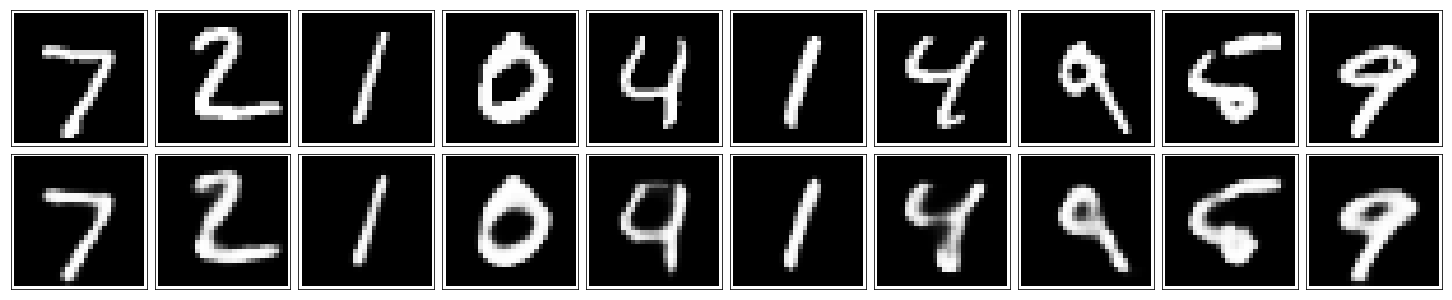

Epoch: 16/20	 Training Loss: 0.1042
Epoch: 16/20	 Training Loss: 0.1003
Epoch: 16/20	 Training Loss: 0.0982
Epoch: 16/20	 Training Loss: 0.0992
Epoch: 16/20	 Training Loss: 0.0994
Epoch: 16/20	 Training Loss: 0.0987
Epoch: 16/20	 Training Loss: 0.1033
Epoch: 16/20	 Training Loss: 0.1054
Epoch: 16/20	 Training Loss: 0.1025
Epoch: 16/20	 Training Loss: 0.1025
Epoch: 16/20	 Training Loss: 0.1033
Epoch: 16/20	 Training Loss: 0.1033
Epoch: 16/20	 Training Loss: 0.0987
Epoch: 16/20	 Training Loss: 0.1026
Epoch: 16/20	 Training Loss: 0.0998
Epoch: 16/20	 Training Loss: 0.0995
Epoch: 16/20	 Training Loss: 0.1019
Epoch: 16/20	 Training Loss: 0.0982
Epoch: 16/20	 Training Loss: 0.1005
Epoch: 16/20	 Training Loss: 0.1008
Epoch: 16/20	 Training Loss: 0.1009
Epoch: 16/20	 Training Loss: 0.0978
Epoch: 16/20	 Training Loss: 0.0996
Epoch: 16/20	 Training Loss: 0.1033
Epoch: 16/20	 Training Loss: 0.1004
Epoch: 16/20	 Training Loss: 0.1021
Epoch: 16/20	 Training Loss: 0.0994
Epoch: 16/20	 Training Loss:

Epoch: 16/20	 Training Loss: 0.1036
Epoch: 16/20	 Training Loss: 0.1011
Epoch: 16/20	 Training Loss: 0.1010
Epoch: 16/20	 Training Loss: 0.0982
Epoch: 16/20	 Training Loss: 0.1055
Epoch: 16/20	 Training Loss: 0.1007
Epoch: 16/20	 Training Loss: 0.0997
Epoch: 16/20	 Training Loss: 0.0971
Epoch: 16/20	 Training Loss: 0.1022
Epoch: 16/20	 Training Loss: 0.0986
Epoch: 16/20	 Training Loss: 0.0994
Epoch: 16/20	 Training Loss: 0.1029
Epoch: 16/20	 Training Loss: 0.1042
Epoch: 16/20	 Training Loss: 0.0988
Epoch: 16/20	 Training Loss: 0.1018
Epoch: 16/20	 Training Loss: 0.0979
Epoch: 16/20	 Training Loss: 0.1028
Epoch: 16/20	 Training Loss: 0.0976
Epoch: 16/20	 Training Loss: 0.1009
Epoch: 16/20	 Training Loss: 0.0988
Epoch: 16/20	 Training Loss: 0.1031
Epoch: 16/20	 Training Loss: 0.1026
Epoch: 16/20	 Training Loss: 0.1018
Epoch: 16/20	 Training Loss: 0.0980
Epoch: 16/20	 Training Loss: 0.1007
Epoch: 16/20	 Training Loss: 0.1024
Epoch: 16/20	 Training Loss: 0.1000
Epoch: 16/20	 Training Loss:

Epoch: 17/20	 Training Loss: 0.0983
Epoch: 17/20	 Training Loss: 0.0984
Epoch: 17/20	 Training Loss: 0.0972
Epoch: 17/20	 Training Loss: 0.0987
Epoch: 17/20	 Training Loss: 0.1017
Epoch: 17/20	 Training Loss: 0.1010
Epoch: 17/20	 Training Loss: 0.1019
Epoch: 17/20	 Training Loss: 0.1016
Epoch: 17/20	 Training Loss: 0.0994
Epoch: 17/20	 Training Loss: 0.0955
Epoch: 17/20	 Training Loss: 0.1022
Epoch: 17/20	 Training Loss: 0.1003
Epoch: 17/20	 Training Loss: 0.0980
Epoch: 17/20	 Training Loss: 0.0987
Epoch: 17/20	 Training Loss: 0.0994
Epoch: 17/20	 Training Loss: 0.1000
Epoch: 17/20	 Training Loss: 0.0987
Epoch: 17/20	 Training Loss: 0.0997
Epoch: 17/20	 Training Loss: 0.0965
Epoch: 17/20	 Training Loss: 0.1010
Epoch: 17/20	 Training Loss: 0.1009
Epoch: 17/20	 Training Loss: 0.1019
Epoch: 17/20	 Training Loss: 0.1012
Epoch: 17/20	 Training Loss: 0.0998
Epoch: 17/20	 Training Loss: 0.0974
Epoch: 17/20	 Training Loss: 0.1009
Epoch: 17/20	 Training Loss: 0.1016
Epoch: 17/20	 Training Loss:

Epoch: 18/20	 Training Loss: 0.0981
Epoch: 18/20	 Training Loss: 0.1012
Epoch: 18/20	 Training Loss: 0.1018
Epoch: 18/20	 Training Loss: 0.0993
Epoch: 18/20	 Training Loss: 0.1006
Epoch: 18/20	 Training Loss: 0.1017
Epoch: 18/20	 Training Loss: 0.0984
Epoch: 18/20	 Training Loss: 0.0965
Epoch: 18/20	 Training Loss: 0.0977
Epoch: 18/20	 Training Loss: 0.1012
Epoch: 18/20	 Training Loss: 0.0985
Epoch: 18/20	 Training Loss: 0.0991
Epoch: 18/20	 Training Loss: 0.0994
Epoch: 18/20	 Training Loss: 0.0995
Epoch: 18/20	 Training Loss: 0.1020
Epoch: 18/20	 Training Loss: 0.0964
Epoch: 18/20	 Training Loss: 0.0965
Epoch: 18/20	 Training Loss: 0.0974
Epoch: 18/20	 Training Loss: 0.1030
Epoch: 18/20	 Training Loss: 0.1016
Epoch: 18/20	 Training Loss: 0.1007
Epoch: 18/20	 Training Loss: 0.0977
Epoch: 18/20	 Training Loss: 0.1014
Epoch: 18/20	 Training Loss: 0.0985
Epoch: 18/20	 Training Loss: 0.0971
Epoch: 18/20	 Training Loss: 0.1016
Epoch: 18/20	 Training Loss: 0.1002
Epoch: 18/20	 Training Loss:

Epoch: 19/20	 Training Loss: 0.1002
Epoch: 19/20	 Training Loss: 0.0980
Epoch: 19/20	 Training Loss: 0.1016
Epoch: 19/20	 Training Loss: 0.0982
Epoch: 19/20	 Training Loss: 0.0930
Epoch: 19/20	 Training Loss: 0.0989
Epoch: 19/20	 Training Loss: 0.0973
Epoch: 19/20	 Training Loss: 0.0970
Epoch: 19/20	 Training Loss: 0.0980
Epoch: 19/20	 Training Loss: 0.1008
Epoch: 19/20	 Training Loss: 0.1004
Epoch: 19/20	 Training Loss: 0.0992
Epoch: 19/20	 Training Loss: 0.1023
Epoch: 19/20	 Training Loss: 0.0996
Epoch: 19/20	 Training Loss: 0.0999
Epoch: 19/20	 Training Loss: 0.1005
Epoch: 19/20	 Training Loss: 0.0996
Epoch: 19/20	 Training Loss: 0.1024
Epoch: 19/20	 Training Loss: 0.0980
Epoch: 19/20	 Training Loss: 0.0999
Epoch: 19/20	 Training Loss: 0.1002
Epoch: 19/20	 Training Loss: 0.0979
Epoch: 19/20	 Training Loss: 0.1001
Epoch: 19/20	 Training Loss: 0.0990
Epoch: 19/20	 Training Loss: 0.1010
Epoch: 19/20	 Training Loss: 0.0972
Epoch: 19/20	 Training Loss: 0.0983
Epoch: 19/20	 Training Loss:

In [12]:
# Run and Save the Trained Model
with tf.Session() as sess:
    sess.run(init)
    
    # Save Current Session Graph
    writer = tf.summary.FileWriter('./output/mnist', sess.graph)
    
    # Number of Epochs to run for
    epochs= 20
    # Batch Size: Number of Images in each batch of Input Data
    batch_size = 200
    # Number of Batches
    n_batches = mnist.train.num_examples // batch_size
    
    for i in range(epochs):
        for j in range(n_batches):
            # Next Batch of Data
            batch = mnist.train.next_batch(batch_size)
            # Load Images
            img = batch[0].reshape((-1,28,28,1))
            # Run the Optimizer and Cost Functions
            result, loss_val = sess.run([optimizer, cost], feed_dict={input_image: img, target_image: img})
            
            print("Epoch: {}/{}\t".format(i,epochs),"Training Loss: {:.4f}".format(loss_val))
        
        # Plot Data from Decoder Output after every 5 Epochs
        if i % 5 == 0:
            decoder_out = sess.run(decoded_image, feed_dict={input_image: test_images.reshape((10, 28, 28, 1))})
            plot_images(decoder_out)
    
    writer.close()
    
    # Save Trained Model
    save_model.save(sess,'./trained_model/mnist/')